# Recurrent neural networks

# Task 1

Get IBM stock market data and evaluate prediction on a set of recurrent neural networks.

Dataset can be downloaded from https://www.kaggle.com/szrlee/stock-time-series-20050101-to-20171231



## Subtask 1

Load data and prepare the dataset

In [254]:
#Write your code here

In [255]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import math
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from keras.layers import *
from keras.models import *
from sklearn.metrics import mean_squared_error
from keras.callbacks import *
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

<AxesSubplot:>

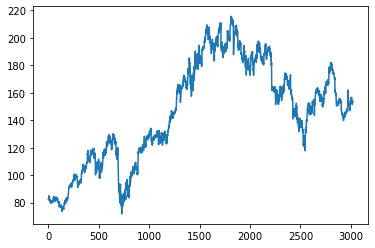

In [256]:
import pandas as pd

df_ibm=pd.read_csv(r'C:\Users\E0IN\Desktop\CC\DJIA\IBM_2006-01-01_to_2018-01-01.csv')
df_ibm['Close'].plot(figsize=(6,4))

In [257]:
#Generic Function

def sliding_window(train, window):
    x = []
    y = []  
    for i in range(0, len(train)-window):
        #print(i)
        #print(train[i:window+i])
        x_train = train[i:window+i]
        y_train = train[i+window]
        x.append(x_train)
        y.append(y_train)
    x = np.asarray(x)
    y = np.asarray(y).reshape(-1,)
    return x,y

In [258]:
df_ibm=pd.read_csv(r'C:\Users\E0IN\Desktop\CC\DJIA\IBM_2006-01-01_to_2018-01-01.csv',index_col="Date",parse_dates=['Date'])
df_ibm

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,82.45,82.55,80.81,82.06,11715200,IBM
2006-01-04,82.20,82.50,81.33,81.95,9840600,IBM
2006-01-05,81.40,82.90,81.00,82.50,7213500,IBM
2006-01-06,83.95,85.03,83.41,84.95,8197400,IBM
2006-01-09,84.10,84.25,83.38,83.73,6858200,IBM
...,...,...,...,...,...,...
2017-12-22,151.82,153.00,151.50,152.50,2990583,IBM
2017-12-26,152.51,153.86,152.50,152.83,2479017,IBM
2017-12-27,152.95,153.18,152.61,153.13,2149257,IBM


In [259]:
df_ibm_copy=df_ibm.copy()
df_ibm_copy.drop(labels=['Volume','Name'],axis=1,inplace=True)

In [260]:
df_close = df_ibm['Close'].dropna()
df_close.isnull().sum()

0

In [261]:
training_set = df_close[:'2016']
test_set = df_close['2017':]
real_prices=test_set.values
print(len(training_set))
print(len(test_set))

2769
251


In [262]:
fig  = make_subplots()
fig.add_trace(go.Scatter(x=df_close.index,y=df_close.values,name="Zoom"))
fig.update_layout(autosize=True,width=900,height=500,title_text="IBM")
fig.update_xaxes(title_text="year")
fig.update_yaxes(title_text="prices")
fig.show()

In [263]:
#Scaling the training data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(training_set.values.reshape(-1,1))
scaled_data.shape

(2769, 1)

In [264]:
#Prepare training Data
window_size=20

Xtrain, ytrain = sliding_window(scaled_data,window_size)
print(Xtrain.shape)
print(ytrain.shape)

(2749, 20, 1)
(2749,)


In [265]:
#Preparing test set
real_prices = test_set.values
total_dataset = pd.concat((training_set, test_set), axis=0)
len_train_data = len(total_dataset)-len(test_set)

model_inputs = total_dataset[len_train_data-window_size:].values
model_inputs = model_inputs.reshape(-1,1) # -1 here indicated that we keep the same the dimension meaning dimension (3,) becomes here (3,1)

# Normalzing the model inputs as we did previously but now for the test data inputs
model_inputs = scaler.transform(model_inputs)
print(len_train_data)

2769


In [266]:
# Preparing x_test 
x_test = []
for day in range(window_size,len(model_inputs)):
    x_test.append(model_inputs[day-window_size:day,0])

x_test = np.array(x_test)
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))
x_test.shape

(251, 20, 1)

In [267]:
# ytrain = np.reshape(Xtrain, (Xtrain.shape[0], Xtrain.shape[1], 1))
# ytest = np.reshape(Xtest, (Xtest.shape[0], Xtest.shape[1], 1))
print(Xtrain.shape)
print(ytrain.shape)
# print(Xtest.shape)
# print(ytest.shape)

(2749, 20, 1)
(2749,)


# Subtask 2

Perform prediction by using feed-forward neural network (sliding window)

In [268]:
feed_forward=Sequential()
feed_forward.add(Flatten(input_shape=(Xtrain.shape[1],1)))
feed_forward.add(Dense(20,activation = 'relu'))
feed_forward.add(Dense(10,activation = 'relu'))
feed_forward.add(Dense(1,activation = 'sigmoid'))
feed_forward.summary()

Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_8 (Flatten)          (None, 20)                0         
_________________________________________________________________
dense_93 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_94 (Dense)             (None, 10)                210       
_________________________________________________________________
dense_95 (Dense)             (None, 1)                 11        
Total params: 641
Trainable params: 641
Non-trainable params: 0
_________________________________________________________________


In [269]:
feed_forward.compile(loss='mse',optimizer='adam',metrics="mse")

In [270]:
h1 = feed_forward.fit(Xtrain, ytrain,epochs=100,batch_size=128)

Epoch 1/100
22/22 [==============================] - 0s 1ms/step - loss: 0.1091 - mse: 0.1091
Epoch 2/100
22/22 [==============================] - 0s 2ms/step - loss: 0.0738 - mse: 0.0738
Epoch 3/100
22/22 [==============================] - 0s 1ms/step - loss: 0.0627 - mse: 0.0627
Epoch 4/100
22/22 [==============================] - 0s 1ms/step - loss: 0.0533 - mse: 0.0533
Epoch 5/100
22/22 [==============================] - 0s 2ms/step - loss: 0.0447 - mse: 0.0447
Epoch 6/100
22/22 [==============================] - 0s 1ms/step - loss: 0.0364 - mse: 0.0364
Epoch 7/100
22/22 [==============================] - 0s 2ms/step - loss: 0.0289 - mse: 0.0289
Epoch 8/100
22/22 [==============================] - 0s 2ms/step - loss: 0.0222 - mse: 0.0222
Epoch 9/100
22/22 [==============================] - 0s 1ms/step - loss: 0.0161 - mse: 0.0161
Epoch 10/100
22/22 [==============================] - 0s 1ms/step - loss: 0.0106 - mse: 0.0106
Epoch 11/100
22/22 [==============================] - 0s 2m

22/22 [==============================] - 0s 1ms/step - loss: 6.5880e-04 - mse: 6.5880e-04
Epoch 84/100
22/22 [==============================] - 0s 1ms/step - loss: 6.4717e-04 - mse: 6.4717e-04
Epoch 85/100
22/22 [==============================] - 0s 1ms/step - loss: 6.4205e-04 - mse: 6.4205e-04
Epoch 86/100
22/22 [==============================] - 0s 1ms/step - loss: 6.3954e-04 - mse: 6.3954e-04
Epoch 87/100
22/22 [==============================] - 0s 1ms/step - loss: 6.5790e-04 - mse: 6.5790e-04
Epoch 88/100
22/22 [==============================] - 0s 1ms/step - loss: 6.3430e-04 - mse: 6.3430e-04
Epoch 89/100
22/22 [==============================] - 0s 1ms/step - loss: 6.4214e-04 - mse: 6.4214e-04
Epoch 90/100
22/22 [==============================] - 0s 1ms/step - loss: 6.5035e-04 - mse: 6.5035e-04
Epoch 91/100
22/22 [==============================] - 0s 1ms/step - loss: 6.3932e-04 - mse: 6.3932e-04
Epoch 92/100
22/22 [==============================] - 0s 1ms/step - loss: 6.2629e-04 -

In [271]:
print(Xtrain.shape)
print(ytrain.shape)

(2749, 20, 1)
(2749,)


In [272]:
# predict the prices
predicted_prices = feed_forward.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)
predicted_prices.shape

(251, 1)

In [273]:
mse1 = mean_squared_error(test_set,predicted_prices.flatten())
print(mse1)

7.646812851429906


In [274]:
fig=make_subplots()
fig.add_trace(go.Scatter(x=training_set.index,y=training_set.values,name="IBM Train"))
fig.add_trace(go.Scatter(x=test_set.index,y=test_set.values,name="IBM Test"))
fig.add_trace(go.Scatter(x=test_set.index,y=predicted_prices.flatten(),name="Predicted price after 2017 year"))
fig.update_layout(autosize=True,width=900,height=500,title_text="IBM")
fig.update_xaxes(title_text="year")
fig.update_yaxes(title_text="prices")
fig.show()

## Subtask 3

Perform prediction by using RNN

In [275]:
rnn = Sequential()
rnn.add(InputLayer(input_shape=(Xtrain.shape[1],1)))
rnn.add(SimpleRNN(80,activation='relu'))
rnn.add(Dense(40,activation='relu'))
rnn.add(Dense(20,activation='relu'))
rnn.add(Dense(1,activation='sigmoid'))
rnn.summary()
Xtrain.shape

Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_7 (SimpleRNN)     (None, 80)                6560      
_________________________________________________________________
dense_96 (Dense)             (None, 40)                3240      
_________________________________________________________________
dense_97 (Dense)             (None, 20)                820       
_________________________________________________________________
dense_98 (Dense)             (None, 1)                 21        
Total params: 10,641
Trainable params: 10,641
Non-trainable params: 0
_________________________________________________________________


(2749, 20, 1)

In [276]:
rnn.compile(loss='mse',optimizer="adam",metrics="mse")

In [277]:
h2 = rnn.fit(Xtrain, ytrain,epochs=100,batch_size=128)

Epoch 1/100
22/22 [==============================] - 1s 9ms/step - loss: 0.0625 - mse: 0.0625
Epoch 2/100
22/22 [==============================] - 0s 8ms/step - loss: 0.0400 - mse: 0.0400
Epoch 3/100
22/22 [==============================] - 0s 8ms/step - loss: 0.0124 - mse: 0.0124
Epoch 4/100
22/22 [==============================] - 0s 9ms/step - loss: 0.0014 - mse: 0.0014
Epoch 5/100
22/22 [==============================] - 0s 9ms/step - loss: 9.9823e-04 - mse: 9.9823e-04
Epoch 6/100
22/22 [==============================] - 0s 8ms/step - loss: 0.0010 - mse: 0.0010
Epoch 7/100
22/22 [==============================] - 0s 8ms/step - loss: 9.0483e-04 - mse: 9.0483e-04
Epoch 8/100
22/22 [==============================] - 0s 11ms/step - loss: 8.2216e-04 - mse: 8.2216e-04
Epoch 9/100
22/22 [==============================] - 0s 10ms/step - loss: 7.6577e-04 - mse: 7.6577e-04
Epoch 10/100
22/22 [==============================] - 0s 11ms/step - loss: 7.2746e-04 - mse: 7.2746e-04
Epoch 11/100
22/

22/22 [==============================] - 0s 10ms/step - loss: 2.5276e-04 - mse: 2.5276e-04
Epoch 81/100
22/22 [==============================] - 0s 9ms/step - loss: 2.5784e-04 - mse: 2.5784e-04
Epoch 82/100
22/22 [==============================] - 0s 9ms/step - loss: 2.5995e-04 - mse: 2.5995e-04
Epoch 83/100
22/22 [==============================] - 0s 9ms/step - loss: 2.5334e-04 - mse: 2.5334e-04
Epoch 84/100
22/22 [==============================] - 0s 9ms/step - loss: 2.4363e-04 - mse: 2.4363e-04
Epoch 85/100
22/22 [==============================] - 0s 9ms/step - loss: 2.3770e-04 - mse: 2.3770e-04
Epoch 86/100
22/22 [==============================] - 0s 10ms/step - loss: 2.3077e-04 - mse: 2.3077e-04
Epoch 87/100
22/22 [==============================] - 0s 9ms/step - loss: 2.4186e-04 - mse: 2.4186e-04
Epoch 88/100
22/22 [==============================] - 0s 9ms/step - loss: 2.6132e-04 - mse: 2.6132e-04
Epoch 89/100
22/22 [==============================] - 0s 9ms/step - loss: 2.5315e-04

In [278]:
predicted_prices = rnn.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices) # Have to inverse transform to "un-normalize" the values
mse2 = mean_squared_error(test_set,predicted_prices.flatten())
print(mse2)

2.7841572185224264


In [279]:
fig=make_subplots()
fig.add_trace(go.Scatter(x=training_set.index,y=training_set.values,name="IBM Train"))
fig.add_trace(go.Scatter(x=test_set.index,y=test_set.values,name="IBM Test"))
fig.add_trace(go.Scatter(x=test_set.index,y=predicted_prices.flatten(),name="Predicted price after year 2017"))
fig.update_layout(autosize=True,width=900,height=500,title_text="IBM")
fig.update_xaxes(title_text="year")
fig.update_yaxes(title_text="prices")
fig.show()

## Subtask 4

Perform prediction by using LSTM

In [280]:
# The LSTM architecture

lstm = Sequential()    
lstm.add(InputLayer(input_shape=(Xtrain.shape[1], 1)))
lstm.add(Dense(50, activation='relu'))
lstm.add(LSTM(units = 25,activation = "relu"))                                    
lstm.add(Dense(20,activation = "relu"))
lstm.add(Dense(units=1, activation = "linear"))

# Compiling the RNN
lstm.compile(optimizer='adam',loss='mean_squared_error',metrics="mse")
lstm.summary()

Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_99 (Dense)             (None, 20, 50)            100       
_________________________________________________________________
lstm_29 (LSTM)               (None, 25)                7600      
_________________________________________________________________
dense_100 (Dense)            (None, 20)                520       
_________________________________________________________________
dense_101 (Dense)            (None, 1)                 21        
Total params: 8,241
Trainable params: 8,241
Non-trainable params: 0
_________________________________________________________________


In [281]:
h3=lstm.fit(Xtrain,ytrain,epochs=100,batch_size=128)

Epoch 1/100
22/22 [==============================] - 2s 14ms/step - loss: 0.0748 - mse: 0.0748
Epoch 2/100
22/22 [==============================] - 1s 25ms/step - loss: 0.0076 - mse: 0.0076
Epoch 3/100
22/22 [==============================] - 0s 22ms/step - loss: 0.0027 - mse: 0.0027
Epoch 4/100
22/22 [==============================] - 0s 19ms/step - loss: 0.0013 - mse: 0.0013
Epoch 5/100
22/22 [==============================] - 0s 17ms/step - loss: 9.3155e-04 - mse: 9.3155e-04
Epoch 6/100
22/22 [==============================] - 0s 19ms/step - loss: 8.2852e-04 - mse: 8.2852e-04
Epoch 7/100
22/22 [==============================] - 0s 20ms/step - loss: 7.6199e-04 - mse: 7.6199e-04
Epoch 8/100
22/22 [==============================] - 0s 18ms/step - loss: 7.0530e-04 - mse: 7.0530e-04
Epoch 9/100
22/22 [==============================] - 0s 22ms/step - loss: 6.5623e-04 - mse: 6.5623e-04
Epoch 10/100
22/22 [==============================] - 0s 15ms/step - loss: 6.1028e-04 - mse: 6.1028e-04
E

22/22 [==============================] - 0s 15ms/step - loss: 1.9668e-04 - mse: 1.9668e-04
Epoch 80/100
22/22 [==============================] - 0s 14ms/step - loss: 2.2508e-04 - mse: 2.2508e-04
Epoch 81/100
22/22 [==============================] - 0s 14ms/step - loss: 1.9064e-04 - mse: 1.9064e-04
Epoch 82/100
22/22 [==============================] - 0s 14ms/step - loss: 1.8520e-04 - mse: 1.8520e-04
Epoch 83/100
22/22 [==============================] - 0s 14ms/step - loss: 1.8867e-04 - mse: 1.8867e-04
Epoch 84/100
22/22 [==============================] - 0s 18ms/step - loss: 1.8268e-04 - mse: 1.8268e-04
Epoch 85/100
22/22 [==============================] - 0s 15ms/step - loss: 1.8939e-04 - mse: 1.8939e-04
Epoch 86/100
22/22 [==============================] - 0s 15ms/step - loss: 1.8774e-04 - mse: 1.8774e-04
Epoch 87/100
22/22 [==============================] - 0s 14ms/step - loss: 1.9295e-04 - mse: 1.9295e-04
Epoch 88/100
22/22 [==============================] - 0s 14ms/step - loss: 2.

In [282]:
predicted_prices = lstm.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices) # Have to inverse transform to "un-normalize" the values
mse3 = mean_squared_error(test_set,predicted_prices.flatten())
print(mse3)

2.557679685497858


In [283]:
fig=make_subplots()
fig.add_trace(go.Scatter(x=training_set.index,y=training_set.values,name="IBM Train"))
fig.add_trace(go.Scatter(x=test_set.index,y=test_set.values,name="IBM Test"))
fig.add_trace(go.Scatter(x=test_set.index,y=predicted_prices.flatten(),name="Predicted price after year 2017"))
fig.update_layout(autosize=True,width=900,height=500,title_text="IBM")
fig.update_xaxes(title_text="year")
fig.update_yaxes(title_text="prices")
fig.show()

## Subtask 5

Compare all above results by using MSE error and dermine the best architecture. You can do tests on more stock data than IBM.

In [284]:
print("Feed forward MSE:",mse1)
print("RNN MSE:",mse2)
print("LSTM MSE:",mse3)

Feed forward MSE: 7.646812851429906
RNN MSE: 2.7841572185224264
LSTM MSE: 2.557679685497858


LSTM model having least MSE than compared to RNN models and Feed Forward model. LSTM is the best architecture for the time series data.